In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
data_one = pd.read_csv("data/2000to2012.csv")
data_two = pd.read_csv("data/2012to2014.csv")
data_three = pd.read_csv("data/jan2015toDec2016.csv")
data_four = pd.read_csv("data/jan2017upwards.csv")

data_one.drop(columns=["block","street_name"])
data_two.drop(columns=["block","street_name"])
data_three.drop(columns=["block","street_name"])
data_four.drop(columns=["block","street_name"])

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...
174990,2024-03,YISHUN,5 ROOM,01 TO 03,121.0,Improved,1987,62 years 07 months,613000.0
174991,2024-03,YISHUN,5 ROOM,07 TO 09,122.0,Improved,1988,62 years 11 months,745000.0
174992,2024-03,YISHUN,EXECUTIVE,01 TO 03,145.0,Maisonette,1988,63 years 05 months,820000.0
174993,2024-03,YISHUN,EXECUTIVE,10 TO 12,146.0,Apartment,1987,62 years 07 months,851888.0


In [20]:
CPIData = pd.read_csv('data\PercentChangeInConsumerPriceIndexCPIOverPreviousPeriod2019AsBaseYearMonthly.csv', header=None)
datetoextract = CPIData.iloc[0]
indextoextract = CPIData.iloc[67]
data = {'Period': datetoextract, 'CPIvalue': indextoextract}
AccomsCPI = pd.DataFrame(data)
AccomsCPI = AccomsCPI.drop(AccomsCPI.index[0])

AccomsCPI[['Year', 'Month']] = AccomsCPI['Period'].str.extract('(\d{4})(\w{3})', expand=True)
AccomsCPI['Date'] = pd.to_datetime(AccomsCPI['Year'] + AccomsCPI['Month'], format='%Y%b')
AccomsCPI = AccomsCPI.sort_values(['Year', 'Date'], ascending=[False, False])
AccomsCPI = AccomsCPI[AccomsCPI['Date'] >= '2000-01-01']
AccomsCPI = AccomsCPI.drop(['Year', 'Month', 'Date'], axis=1)
AccomsCPI.loc[AccomsCPI['CPIvalue'] == 'na', 'CPIvalue'] = 0
AccomsCPI = AccomsCPI.reset_index(drop=True)
AccomsCPI['CPIvalue'] = AccomsCPI['CPIvalue'].astype(float)
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y%b')
AccomsCPI['Period'] = AccomsCPI['Period'].dt.to_period('M')
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)
AccomsCPI.dtypes

Period       object
CPIvalue    float64
dtype: object

In [21]:
cpi_values = AccomsCPI['CPIvalue'].tolist()
AccomsCPI['AdjustmentValue'] = 1

for idx, cpi in enumerate(AccomsCPI['CPIvalue']):
    if idx != 0:
        AccomsCPI.loc[idx, 'AdjustmentValue'] = AccomsCPI.loc[idx - 1, 'AdjustmentValue'] * (1 + (AccomsCPI.loc[idx - 1, 'CPIvalue'] / 100))

AccomsCPI.head()

,Period,CPIvalue,AdjustmentValue
0,2024-01,-2.7,1.000000
1,2023-12,0.2,0.973000
2,2023-11,1.9,0.974946
3,2023-10,-1.4,0.993470
4,2023-09,0.3,0.979561


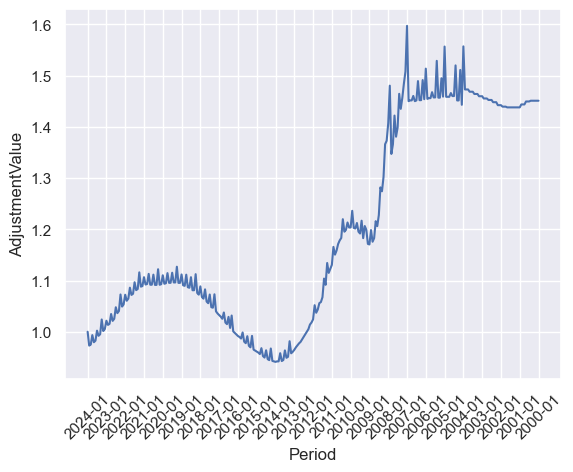

In [23]:
ax = sb.lineplot(data=AccomsCPI, x='Period', y='AdjustmentValue' )
ax.set_xticks(range(0, len(AccomsCPI), 12))  
ax.set_xticklabels([AccomsCPI['Period'][i] for i in range(0, len(AccomsCPI), 12)], rotation=45) 

plt.show()

In [32]:
combined_data = pd.concat([data_one, data_two, data_three, data_four], ignore_index=True)
combined_data = combined_data.sort_values(by='month', ascending=False)
combined_data['remaining_lease'].fillna('NULL', inplace=True)

combined_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease         object
dtype: object

In [37]:
merged_data = pd.merge(combined_data, AccomsCPI, left_on='month', right_on='Period', how='left')
merged_data['AdjustmentValue'].fillna(1, inplace=True)
merged_data['resale_price_adjusted'] = merged_data['resale_price'] * merged_data['AdjustmentValue']
merged_data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Period,CPIvalue,AdjustmentValue,resale_price_adjusted
0,2024-03,YISHUN,EXECUTIVE,606,YISHUN ST 61,07 TO 09,142.0,Apartment,1987,780000.0,62 years 10 months,NaN,NaN,1.000000,780000.000000
1,2024-03,HOUGANG,4 ROOM,998A,BUANGKOK CRES,13 TO 15,93.0,Model A,2019,655000.0,94 years 10 months,NaN,NaN,1.000000,655000.000000
2,2024-03,HOUGANG,4 ROOM,601,HOUGANG AVE 4,01 TO 03,84.0,Simplified,1986,475000.0,61 years 04 months,NaN,NaN,1.000000,475000.000000
3,2024-03,HOUGANG,4 ROOM,17,HOUGANG AVE 3,07 TO 09,98.0,New Generation,1978,538000.0,53 years 03 months,NaN,NaN,1.000000,538000.000000
4,2024-03,HOUGANG,4 ROOM,709,HOUGANG AVE 2,10 TO 12,91.0,New Generation,1985,538000.0,60 years 05 months,NaN,NaN,1.000000,538000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633997,2000-01,QUEENSTOWN,3 ROOM,166,STIRLING RD,01 TO 03,60.0,Improved,1970,155000.0,NULL,2000-01,0.0,1.450914,224891.697898
633998,2000-01,QUEENSTOWN,3 ROOM,161,MEI LING ST,01 TO 03,72.0,Improved,1970,182000.0,NULL,2000-01,0.0,1.450914,264066.380757
633999,2000-01,QUEENSTOWN,3 ROOM,161,MEI LING ST,04 TO 06,72.0,Improved,1970,186000.0,NULL,2000-01,0.0,1.450914,269870.037477
634000,2000-01,QUEENSTOWN,3 ROOM,161,MEI LING ST,16 TO 18,72.0,Improved,1970,208000.0,NULL,2000-01,0.0,1.450914,301790.149437
